In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.io import loadmat
from datetime import datetime, timedelta
sys.path.append('/home/manu/TFG_repo/scripts')

In [261]:
from analysis_routines import *
from config import data_dir, reports_dir
from plotting_routines_xr import *
from processing_routines import datenum_to_epoch
from wavelet_analysis import wavelet_power_spectrum
from harmonic_analysis import *
from scipy.stats import chi2
plt.style.use('/home/manu/TFG_repo/notebooks/report.mplstyle')

In [175]:
# load data and fit
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
station7 = load_time_series_xr('station7_complete.nc')
G05 = pd.read_csv(data_dir / 'SHDR_fit/aux/G05.csv', index_col='date', parse_dates=True)
delta05 = pd.read_csv(data_dir / 'SHDR_fit/aux/delta05_ci.csv', index_col='date', parse_dates=True)

In [7]:
# global variables
figures_dir = reports_dir / 'figures'
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [161]:
def get_figsize(wf=0.5, hf=None, columnwidth=455.24411):
    """Parameters:
      - wf (float):  width fraction in columnwidth units
      - hf (float):  height fraction in columnwidth units.
                   Set by default to golden ratio.
      - columnwidth (float): width of the column in latex. Get this from LaTeX 
                               using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    
    if hf is None:
        hf = 1/1.333333
    
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

1.333333

# Capitulo 1: Conceptos básicos de onceanografía física

[4.409448969143489, 3.307087553629505]


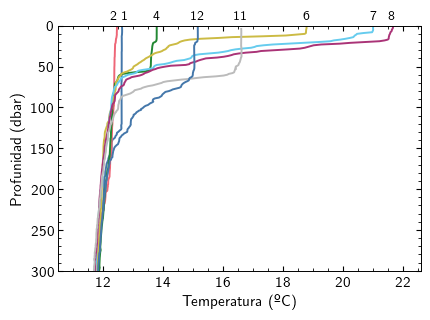

In [85]:
# profiles_2014
figsize = get_figsize(0.7)
print(figsize)
fig, ax = plt.subplots(figsize=figsize)
year = station7.temp.sel(date='2014')
months_int = [0, 1, 3, 5, 6, 7, 10, 11]
for i in months_int:
    #k = i*2 + 1
    ax.plot(year[i], station7.pres)
    if i==0:
        ax.text(year[i][np.isfinite(year[i])][3] +0.1, -8, i + 1, ha='center')
    elif i==1:
        ax.text(year[i][np.isfinite(year[i])][3] -0.1, -8, i + 1, ha='center')     
    else:
        ax.text(year[i][np.isfinite(year[i])][3], -8, i + 1, ha='center')
ax.set_ylim(300, 0)
ax.set_xlim(10.5, None)
ax.set_xlabel('Temperatura (ºC)')
ax.set_ylabel('Profunidad (dbar)')
fig.tight_layout()
fig.savefig(reports_dir / 'figures/profiles_2014.pdf', dpi=300)
plt.show()

In [93]:
chain.depth

<xarray.DataArray 'depth' (depth: 16)>
array([  1,   8,  23,  28,  33,  43,  48,  53,  63,  78,  96, 108, 126, 151,
       176, 201], dtype=int32)
Coordinates:
  * depth    (depth) int32 1 8 23 28 33 43 48 53 63 78 96 108 126 151 176 201

# Capitulo 5: Ondas internas

In [94]:
# espectros termistores welch

temp_28 = chain.temp.loc[:, 28].data
freqs_28, psd_28, dof_28 = windowed_spectrum(temp_28, 5/60/60/24, 28, 3) #window 42.67

temp_53 = chain.temp.loc[:, 53].data
freqs_53, psd_53, dof_53 = windowed_spectrum(temp_53, 5/60/60/24, 28, 3) #window 42.67

temp_63 = chain.temp.loc[:, 63].data
freqs_63, psd_63, dof_63 = windowed_spectrum(temp_63, 5/60/60/24, 28, 3) #window 42.673

temp_96 = chain.temp.loc[:, 96].data
freqs_96, psd_96, dof_96 = windowed_spectrum(temp_96, 5/60/60/24, 28, 3) #window 42.67

temp_126 = chain.temp.loc[:, 126].data
freqs_126, psd_126, dof_126 = windowed_spectrum(temp_126, 5/60/60/24, 28, 3) #window 42.67

temp_176 = chain.temp.loc[:, 176].data
freqs_176, psd_176, dof_176 = windowed_spectrum(temp_176, 5/60/60/24, 28, 3) #window 42.67

In [325]:
# espectros parámetros ajuste
D1_ = fit_chain['D1']
freqs_D1, psd_D1, dof_D1 = windowed_spectrum(D1_, 5/60/60/24, 28, 3) #window 42.67

a2_ = fit_chain['a2']
freqs_a2, psd_a2, dof_a2 = windowed_spectrum(a2_, 5/60/60/24, 28, 3) #window 42.67

a1_ = fit_chain['a1']
freqs_a1, psd_a1, dof_a1 = windowed_spectrum(a1_, 5/60/60/24, 28, 3) #window 42.67

freqs_G05, psd_G05, dof_G05 = windowed_spectrum(G05.x, 5/60/60/24, 28, 3) #window 42.67


In [176]:
coriolis_frequency = 2*7.2921e-5*np.sin(np.deg2rad(chain.lat.data)[0])
coriolis_freq_cps = coriolis_frequency/2/np.pi
coriolis_freq_cpd = coriolis_freq_cps*60*60*24
M2_cpd = 1/12.42061*24
M4_cpd = 1/6.210301*24
K1_cpd = 1/23.934470*24
Q1_cpd = 1/28.006223*24
M3_cpd = 1/8.280401*24
M8_cpd = 1/3.105150*24
O1_cpd = 1/1/25.819351*24 # not present in temperature record
Q1_2_cpd = 1/28.006223*24
M6_cpd = 1/4.14020*24

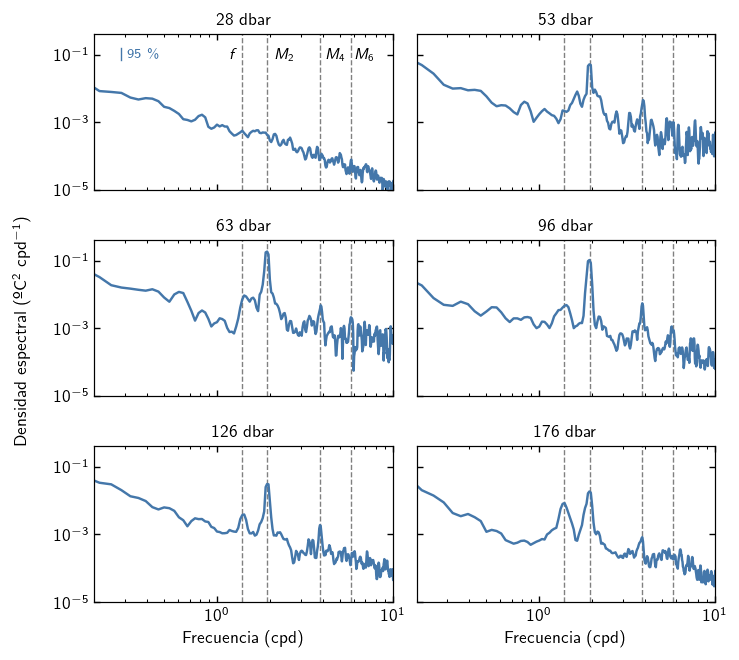

In [408]:
vlines = [coriolis_freq_cpd, M2_cpd, M4_cpd, M6_cpd]
texts = ['f', 'M2', 'M4', ]

figsize=(get_figsize(0.95, 0.9))
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=figsize)

#limits
ylim = (10**-5, 4*10**-1)

axs[0,0].set_xlim(2*10**-1, 10**1)
axs[0,0].set_ylim(ylim)
for ax in axs.reshape(6):
    ax.vlines(vlines, *ylim, ls='--', color='grey', lw=0.8)
axs[0,0].text(vlines[0] - 0.2, 10**-1, '$f$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[1] + 0.2, 10**-1, '$M_2$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[2] + 0.3, 10**-1, '$M_4$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[3] + 0.3, 10**-1, '$M_6$', ha='left', fontsize=9, va='center')


axs[0,0].loglog(freqs_28, psd_28)
axs[0,0].set_title('28 dbar')

axs[0,1].loglog(freqs_53, psd_53)
axs[0,1].set_title('53 dbar')


axs[1,0].loglog(freqs_63, psd_63)
axs[1,0].set_title('63 dbar')


axs[1,1].loglog(freqs_96, psd_96)
axs[1,1].set_title('96 dbar')


axs[2,0].loglog(freqs_126, psd_126)
axs[2,0].set_title('126 dbar')
axs[2,0].set_xlabel('Frecuencia (cpd)')


axs[2,1].loglog(freqs_176, psd_176)
axs[2,1].set_title('176 dbar')
axs[2,1].set_xlabel('Frecuencia (cpd)')


chi_2 = dof_28 / chi2.ppf([0.025, 0.975], dof_28)
y_bar = 10**-1
conf = y_bar * chi_2
axs[0,0].plot([0.09, 0.09], conf, transform=axs[0,0].get_yaxis_transform(), c=colors[0], lw=0.8)
axs[0,0].text(0.11, y_bar, '95 $\%$', transform=axs[0,0].get_yaxis_transform(), fontsize=8, va='center',
             color=colors[0])

fig.supylabel('Densidad espectral (ºC$^2$ cpd$^{-1}$)', fontsize=10)

fig.tight_layout()
fig.subplots_adjust(wspace=0.08)
fig.savefig(figures_dir / 'welch_column.pdf', dpi=300)

plt.gcf().set_dpi(125)
plt.show()

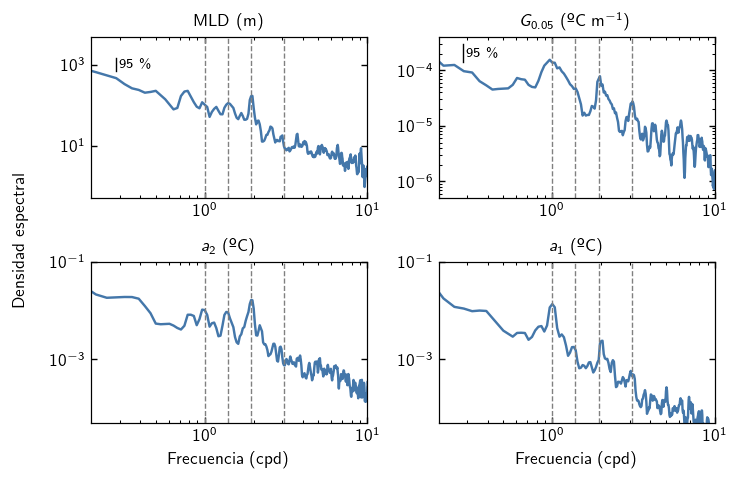

In [407]:
figsize = (get_figsize(0.95, 0.66))
fig = plt.figure(figsize=figsize)
gs = plt.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.loglog(freqs_D1, psd_D1)
ax1.set_ylim(5*10**-1,None)
ax1.set_title('MLD (m)')

#ax1.set_ylabel('Espectro (m$^2$ cpd$^{-1}$)')
#ax1.set_xlabel('Frecuencia (cpd)')


ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(freqs_G05, psd_G05)
ax2.set_ylim(5*10**-7, 4*10**-4)
ax2.set_title('$G_{0.05}$ (ºC m$^{-1}$)')
#ax2.set_ylabel('Espectro (ºC$^2$ m$^{-2}$ cpd$^{-1}$)')
#ax2.set_xlabel('Frecuencia (cpd)')


ax3 = fig.add_subplot(gs[1, 0])
ax3.loglog(freqs_a2, psd_a2)
ax3.set_ylim(5*10**-5, 10**-1)
ax3.set_title('$a_2$ (ºC)')
ax3.set_xlabel('Frecuencia (cpd)')

ax4 = fig.add_subplot(gs[1, 1])
ax4.loglog(freqs_a1, psd_a1)
ax4.set_ylim(5*10**-5, 10**-1)
ax4.set_xlabel('Frecuencia (cpd)')
ax4.set_title('$a_1$ (ºC)')

freq = 1/9*24
vlines = [1, coriolis_freq_cpd, M2_cpd, 1/7.8*24]

for ax in fig.get_axes():
    ax.set_xlim(2*10**-1, 10**1)
    ax.vlines(vlines, *ax.get_ylim(), ls='--', color='grey', lw=0.8)
    

chi_2 = dof_28 / chi2.ppf([0.025, 0.975], dof_28)
y_bar_ax1 = 10**3
ax1.plot([0.09, 0.09], chi_2*y_bar_ax1, transform=ax1.get_yaxis_transform(), c='k', lw=0.8)
ax1.text(0.10, y_bar_ax1, '95 $\%$', transform=ax1.get_yaxis_transform(), fontsize=8, va='center')


y_bar_ax2 = 2*10**-4
ax2.plot([0.09, 0.09], chi_2*y_bar_ax2, transform=ax2.get_yaxis_transform(), c='k', lw=0.8)
ax2.text(0.10, y_bar_ax2, '95 $\%$', transform=ax2.get_yaxis_transform(), fontsize=8, va='center')

fig.supylabel('Densidad espectral', fontsize=10)
fig.tight_layout()
#fig.subplots_adjust(, left=0.092)
fig.savefig(figures_dir / 'welch_parametres.pdf', dpi=300)

plt.gcf().set_dpi(125)
plt.show()

(-2.0, 2.0)

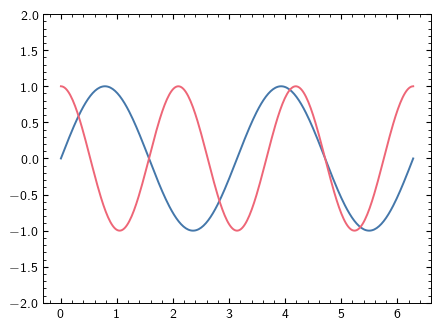

In [242]:
x = np.linspace(0, 2*np.pi, 300)
cpd_1 = 1
cpd_2 = 2
cpd_3 = 3
plt.plot(x, np.sin(cpd_2*x))
plt.plot(x, np.cos(cpd_3*x))
plt.ylim(-2, 2)

In [253]:
24/7.8

3.076923076923077